In [1]:
import chipwhisperer as cw
import matplotlib.pyplot as plt
import numpy as np

import simon_64_128

from helper import KeyHypothesis
import helper

from measurement import Measurement, Measurements

/home/nico/miniconda3/envs/simon/lib/python3.13/site-packages/chipwhisperer/capture/trace/TraceWhisperer.py:31: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources # type: ignore


# Import Trace

In [2]:
project = cw.import_project("./traces/01_simon_plain_1000/trace.zip", overwrite=True)

In [3]:
NUM_MEASUREMENTS = len(project.traces)
print(NUM_MEASUREMENTS)

VALS_PER_MEASUREMENT = len(project.traces[0].wave)
print(VALS_PER_MEASUREMENT)

CORR_DIFF_THRESHOLD = 0.05

1000
5000


# Transform Trace Project into Measurement object

In [4]:
measurements = Measurements()

for trace in project.traces:
    i = trace.textin
    o = trace.textout

    plaintext = np.zeros((2,), dtype=np.uint32)
    plaintext[0] = i[0] << 24 | i[1] << 16 | i[2] << 8 | i[3]
    plaintext[1] = i[4] << 24 | i[5] << 16 | i[6] << 8 | i[7]

    ciphertext = np.zeros((2,), dtype=np.uint32)
    ciphertext[0] = o[0] << 24 | o[1] << 16 | o[2] << 8 | o[3]
    ciphertext[1] = o[4] << 24 | o[5] << 16 | o[6] << 8 | o[7]
    power = np.array(trace.wave, dtype=np.uint32)
    measurements.append(Measurement(plaintext, ciphertext, power))

measurements.update_arrays()


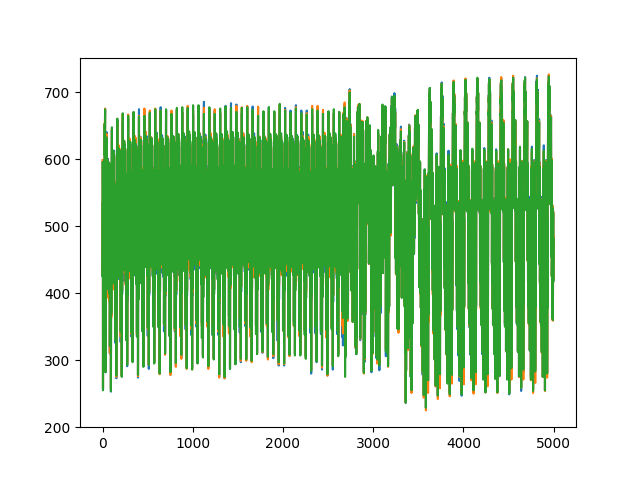

In [5]:
%matplotlib widget

plt.figure()

plt.plot(measurements.entries[0].power)
plt.plot(measurements.entries[1].power)
plt.plot(measurements.entries[2].power)
plt.show()

In [6]:
key = np.array([0x19013660, 0x86de7696, 0xd0427aff, 0x738dd98a], dtype=np.uint32)
# key = np.array([0x1B1A1918, 0x13121110, 0x0B0A0908, 0x03020100], dtype=np.uint32)

pt = measurements.entries[0].plaintext
ct = measurements.entries[0].ciphertext

ct_expect, _ = simon_64_128.encrypt_block(pt, key)

print(ct)
print(ct_expect)

[4125762054 1318223827]
[4125762054 1318223827]


In [7]:
print(measurements.plaintexts.shape)
print(measurements.ciphertexts.shape)
print(measurements.power_2d.shape)

(1000, 2)
(1000, 2)
(1000, 5000)


# Attack

In [8]:
# start with empty key as hypothesis
empty_key = np.zeros((4,), dtype=np.uint32)
start_hypo = KeyHypothesis(empty_key, 0)

promising_hypos = [start_hypo]

for attack_step in range(16):
    print(f"Perform Attack Step {attack_step+1}/16")

    sub_hypos: list[KeyHypothesis] = []

    for h in promising_hypos:
        sub_hypos.extend(h.get_sub_hypos())

    print(f"Find correlations for {len(sub_hypos)} hypotheses.")

    for hypo in sub_hypos:
        helper.calc_corr_for_hypo(hypo, measurements)
    
    promising_hypos = helper.filter_hypos(sub_hypos, CORR_DIFF_THRESHOLD)
    
    print(f"Found {len(promising_hypos)} promising hypotheses.")
    for hypo in promising_hypos:
        
        print(f"{helper.array_to_hex_str(hypo.key)}: correlation: {hypo.corr}")

if len(promising_hypos) > 0:
    # Do final check against ciphertext
    for hypo in promising_hypos:
        ciphertext, _ = simon_64_128.encrypt_block(measurements[0].plaintext, hypo.key)
        if np.array_equal(measurements[0].ciphertext, ciphertext):
            extracted_key = hypo.key
            print(f"Extracted Key: {helper.array_to_hex_str(extracted_key)}")
            break
else:
    print("Could not determine key")

Perform Attack Step 1/16
Find correlations for 256 hypotheses.
Found 2 promising hypotheses.
0x00000000 0x00000000 0x00000000 0x00000075: correlation: 0.3846367335923671
0x00000000 0x00000000 0x00000000 0x0000008A: correlation: -0.384636733592367
Perform Attack Step 2/16
Find correlations for 512 hypotheses.
Found 4 promising hypotheses.
0x00000000 0x00000000 0x00000000 0x00002675: correlation: 0.623329851920613
0x00000000 0x00000000 0x00000000 0x00003675: correlation: 0.5840497726233089
0x00000000 0x00000000 0x00000000 0x0000C98A: correlation: -0.5840497726233089
0x00000000 0x00000000 0x00000000 0x0000D98A: correlation: -0.6233298519206131
Perform Attack Step 3/16
Find correlations for 1024 hypotheses.
Found 4 promising hypotheses.
0x00000000 0x00000000 0x00000000 0x00722675: correlation: 0.7709574955342338
0x00000000 0x00000000 0x00000000 0x00723675: correlation: 0.7306340298843661
0x00000000 0x00000000 0x00000000 0x008DC98A: correlation: -0.7306340298843661
0x00000000 0x00000000 0x0

KeyboardInterrupt: 

# Attack Insights

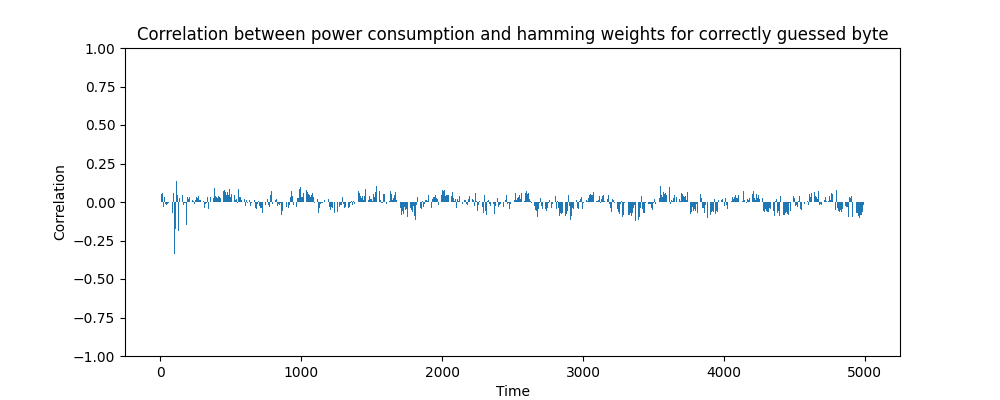

In [7]:
key = np.array([0x19013660, 0x86de7696, 0xd0427aff, 0x738dd98a], dtype=np.uint32)

guessed_key = np.zeros((4,), dtype=np.uint32)
guessed_key[3] |= key[3] & 0xFF

expected_hws = np.array(
        [helper.get_hw_for_guessed_key_byte(m.plaintext, guessed_key, 0, np.uint32(0xFF)) for m in measurements.entries], 
        dtype=np.uint32)

corrs = helper.calc_corrs(expected_hws, measurements.power_2d)

plt.figure(figsize=(10,4))
x = np.arange(len(corrs))
plt.bar(x, corrs)
plt.xlabel("Time")
plt.ylabel("Correlation")
plt.title(f"Correlation between power consumption and hamming weights for correctly guessed byte")
plt.ylim(-1, 1)
plt.show()